## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('RawData/')

In [5]:
type(mylist)

list

In [6]:
print(mylist[1400])

03-01-08-02-02-01-09.wav


In [7]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('RawData/03-01-01-01-01-02-02.wav')

Populating the interactive namespace from numpy and matplotlib


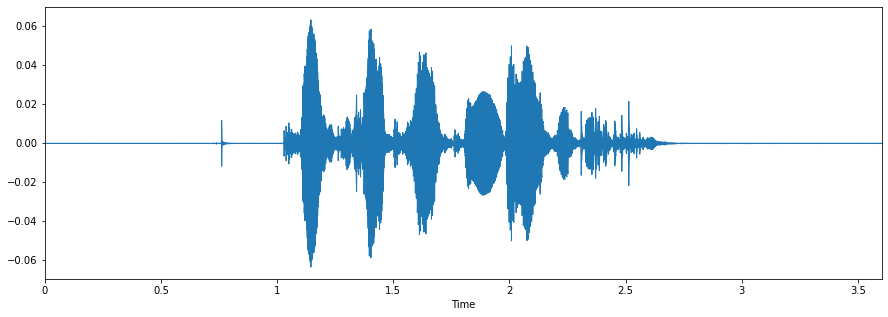

In [9]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

c:\python37\lib\site-packages\ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
c:\python37\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


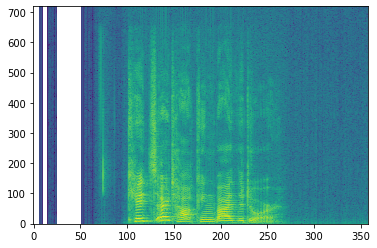

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-01-01-01-01-02-02.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
   # elif item[:1]=='a':
     #   feeling_list.append('male_angry')
    #elif item[:1]=='f':
      #  feeling_list.append('male_fearful')
    #elif item[:1]=='h':
      #  feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    #elif item[:2]=='sa':
       # feeling_list.append('male_sad')

In [12]:
labels = pd.DataFrame(feeling_list)

In [13]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [14]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [15]:
df[:5]

,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-65.70765, -65.70765, -63.11472, -61.518997, ..."
2,"[-65.4825, -65.4825, -65.4825, -65.4825, -65.4..."
3,"[-64.52845, -64.52845, -64.52845, -64.52845, -..."
4,"[-62.36431, -59.934727, -61.869602, -67.49577,..."


In [16]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [17]:
newdf = pd.concat([df3,labels], axis=1)

In [18]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [19]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082741,-60.234661,male_calm
1,-65.707649,-65.707649,-63.114719,-61.518997,-61.097141,-63.424599,-63.720066,-56.854614,-55.168972,-54.639999,...,-39.792141,-40.613159,-41.209202,-41.439201,-43.994286,-49.399620,-50.591599,-49.144051,-48.705654,female_calm
2,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,...,-31.346554,-34.310772,-35.800705,-35.936115,-37.631844,-40.119411,-41.662888,-41.323643,-40.710770,male_calm
3,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-65.928223,...,-48.674301,-48.596073,-47.602745,-43.049198,-42.659542,-43.188560,-44.001244,-43.610100,-44.698246,female_calm
4,-62.364311,-59.934727,-61.869602,-67.495773,-71.071808,-65.679817,-63.394402,-65.503349,-61.856644,-60.005428,...,-39.071327,-41.897121,-40.865437,-38.290615,-36.372398,-37.915779,-40.026127,-43.383774,-43.965401,male_calm


In [20]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
546,-51.184227,-50.666916,-51.630920,-51.646034,-52.121620,-52.546799,-52.472919,-52.978508,-52.645653,-50.576077,...,-53.822239,-52.425518,-52.587624,-53.503574,-52.757423,-52.616047,-54.575233,-53.020237,-50.155544,male_sad
551,-60.209717,-61.792744,-57.893070,-54.121395,-51.305805,-47.766926,-47.981808,-48.230991,-48.983181,-49.097771,...,-40.692318,-37.988586,-37.762260,-39.635742,-39.829453,-37.223740,-36.612770,-29.627529,-23.944246,female_sad
329,-39.220127,-38.967705,-38.299438,-39.797867,-40.150063,-41.485416,-40.066021,-40.926140,-41.405636,-41.089012,...,-32.799198,-38.420891,-38.816059,-39.434536,-40.608849,-40.189308,-41.060795,-42.711063,-42.362637,female_happy
861,-58.343685,-57.758335,-57.390007,-57.915745,-57.707928,-56.975300,-56.616310,-54.947655,-55.302238,-54.532486,...,-54.269615,-56.536839,-57.594933,-55.862270,-53.719467,-52.433254,-53.052410,-54.593563,-55.809261,female_fearful
952,-33.836643,-33.483257,-32.777428,-33.720402,-33.560627,-32.265327,-34.218872,-34.635536,-32.317135,-32.178822,...,-41.730198,-41.561810,-40.342613,-39.866158,-39.367020,-39.435223,-39.430969,-39.294914,-38.841824,male_fearful
228,-58.045681,-56.292679,-54.386772,-54.010464,-56.672066,-58.652714,-63.387592,-64.596809,-60.969406,-58.170113,...,-60.769226,-62.025021,-60.860615,-59.814369,-62.398552,-63.029255,-63.037746,-65.220490,-65.220490,male_happy
860,-54.921909,-54.603817,-56.045567,-56.816208,-56.622986,-55.934166,-55.116272,-52.974819,-54.233871,-55.541855,...,-22.480495,-22.020353,-23.458082,-22.972700,-22.354027,-23.124874,-20.957472,-20.438780,-19.000305,male_fearful
25,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,-65.278046,...,-35.933418,-36.280289,-37.471256,-37.164463,-36.920071,-36.210682,-36.732735,-39.034431,-38.324142,female_calm
147,-55.505390,-57.227497,-59.613701,-59.684994,-58.826515,-58.419609,-58.941689,-58.464092,-57.606888,-58.260513,...,-44.569099,-45.176113,-44.880535,-45.987907,-46.686279,-46.743793,-48.035160,-47.001572,-46.257610,female_calm
126,-57.978149,-55.626396,-55.174358,-56.457298,-56.625481,-54.590164,-56.989632,-56.343628,-57.430222,-58.221031,...,-32.541855,-32.868156,-33.298515,-33.064243,-33.127941,-34.393990,-35.387772,-36.723495,-37.092041,male_calm


In [21]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [22]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [23]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
90,-58.028908,-56.111874,-54.608276,-54.644650,-54.758465,-54.846001,-56.253845,-59.920792,-64.848526,-67.302635,...,-53.023239,-51.637226,-53.899067,-55.300659,-55.775333,-54.993645,-54.727669,-53.576542,-53.942589,male_calm
728,-42.326534,-42.384102,-41.830338,-41.722427,-41.489258,-41.244488,-41.359680,-41.101074,-41.173710,-41.788696,...,-19.884966,-14.869338,-16.391935,-19.206144,-19.625771,-16.581886,-13.264472,-8.564637,-2.037603,male_angry
673,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,-46.882404,...,-34.990402,-34.930424,-37.702351,-38.504726,-40.004250,-40.235683,-40.575851,-42.321167,-43.132748,female_angry
939,-46.300560,-46.300560,-46.300560,-46.300560,-46.300560,-46.300560,-46.300560,-46.300560,-46.300560,-46.300560,...,-44.132755,-43.827019,-45.809067,-46.300560,-45.477909,-45.185856,-46.166191,-46.300560,-46.300560,female_fearful
631,-50.773075,-51.290535,-49.537144,-49.165077,-49.960850,-49.895115,-50.056541,-47.998516,-49.212078,-51.043209,...,-51.971634,-51.041477,-49.913498,-51.230728,-52.506657,-50.665371,-49.479511,-50.153622,-50.676296,female_angry
790,-59.780769,-59.780769,-59.780769,-59.780769,-59.780769,-59.780769,-59.780769,-59.780769,-59.780769,-59.780769,...,-55.317032,-57.339394,-56.978897,-53.936604,-53.569424,-55.385586,-56.995461,-56.024414,-57.494595,male_fearful
403,-78.348274,-78.348274,-78.348274,-78.348274,-78.348274,-78.348274,-78.348274,-78.348274,-78.926430,-76.456818,...,-65.661446,-71.329605,-69.747086,-67.453354,-70.168266,-68.329414,-68.872520,-67.664055,-67.670990,female_sad
615,-47.787777,-47.787777,-47.787777,-47.787777,-47.787777,-47.787777,-47.787777,-47.787777,-47.787777,-47.787777,...,-32.046268,-30.942598,-29.607901,-28.409790,-29.193861,-28.766655,-28.533195,-25.502962,-27.296400,female_angry
460,-61.472904,-59.734550,-60.627815,-68.295822,-73.736893,-67.164810,-60.458965,-59.743877,-62.568974,-60.860291,...,-53.031086,-53.590496,-51.139381,-52.789284,-56.085964,-54.030472,-51.095589,-51.531914,-55.928780,male_sad
566,-50.714653,-52.173477,-51.134502,-50.964436,-54.615986,-52.936970,-51.824238,-53.824482,-54.257042,-52.661983,...,-34.754604,-34.237701,-36.064926,-34.062496,-33.519577,-35.776901,-37.551003,-35.531189,-31.679543,male_sad


In [24]:
trainfeatures = train.iloc[:, :-1]

In [25]:
trainlabel = train.iloc[:, -1:]

In [26]:
testfeatures = test.iloc[:, :-1]

In [27]:
testlabel = test.iloc[:, -1:]

In [28]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


c:\python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [29]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
X_train.shape

(771, 216)

## Changing dimension for CNN model

In [31]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [34]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_10 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_11 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 27, 128)          

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [37]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
49/49 [==============================] - 2s 38ms/step - loss: 2.4368 - accuracy: 0.1008 - val_loss: 2.2974 - val_accuracy: 0.1323
Epoch 2/700
49/49 [==============================] - 2s 33ms/step - loss: 2.3103 - accuracy: 0.1231 - val_loss: 2.3133 - val_accuracy: 0.1323
Epoch 3/700
49/49 [==============================] - 2s 36ms/step - loss: 2.2644 - accuracy: 0.1527 - val_loss: 2.2669 - val_accuracy: 0.1640
Epoch 4/700
49/49 [==============================] - 2s 33ms/step - loss: 2.2332 - accuracy: 0.1575 - val_loss: 2.2439 - val_accuracy: 0.2063
Epoch 5/700
49/49 [==============================] - 2s 34ms/step - loss: 2.1923 - accuracy: 0.2017 - val_loss: 2.2396 - val_accuracy: 0.1852
Epoch 6/700
49/49 [==============================] - 2s 33ms/step - loss: 2.1648 - accuracy: 0.1942 - val_loss: 2.1823 - val_accuracy: 0.2011
Epoch 7/700
49/49 [==============================] - 2s 33ms/step - loss: 2.1684 - accuracy: 0.1938 - val_loss: 2.1687 - val_accuracy: 0.2116
Epoch 

49/49 [==============================] - 2s 33ms/step - loss: 1.5429 - accuracy: 0.4266 - val_loss: 1.7916 - val_accuracy: 0.3545
Epoch 59/700
49/49 [==============================] - 2s 34ms/step - loss: 1.5198 - accuracy: 0.4297 - val_loss: 1.8211 - val_accuracy: 0.3122
Epoch 60/700
49/49 [==============================] - 2s 33ms/step - loss: 1.5250 - accuracy: 0.4416 - val_loss: 1.7843 - val_accuracy: 0.3333
Epoch 61/700
49/49 [==============================] - 2s 33ms/step - loss: 1.5589 - accuracy: 0.4212 - val_loss: 1.7479 - val_accuracy: 0.3228
Epoch 62/700
49/49 [==============================] - 2s 32ms/step - loss: 1.5043 - accuracy: 0.4578 - val_loss: 1.7635 - val_accuracy: 0.3386
Epoch 63/700
49/49 [==============================] - 2s 32ms/step - loss: 1.5880 - accuracy: 0.4257 - val_loss: 1.7720 - val_accuracy: 0.3333
Epoch 64/700
49/49 [==============================] - 2s 33ms/step - loss: 1.4926 - accuracy: 0.4560 - val_loss: 1.7707 - val_accuracy: 0.3175
Epoch 65/700

Epoch 115/700
49/49 [==============================] - 2s 37ms/step - loss: 1.2583 - accuracy: 0.5201 - val_loss: 1.6210 - val_accuracy: 0.3915
Epoch 116/700
49/49 [==============================] - 2s 37ms/step - loss: 1.2620 - accuracy: 0.5266 - val_loss: 1.5684 - val_accuracy: 0.3757
Epoch 117/700
49/49 [==============================] - 2s 37ms/step - loss: 1.3278 - accuracy: 0.5005 - val_loss: 1.5793 - val_accuracy: 0.4074
Epoch 118/700
49/49 [==============================] - 2s 37ms/step - loss: 1.3054 - accuracy: 0.5145 - val_loss: 1.5808 - val_accuracy: 0.3968
Epoch 119/700
49/49 [==============================] - 2s 36ms/step - loss: 1.2499 - accuracy: 0.5471 - val_loss: 1.6103 - val_accuracy: 0.3915
Epoch 120/700
49/49 [==============================] - 2s 36ms/step - loss: 1.2660 - accuracy: 0.5289 - val_loss: 1.6451 - val_accuracy: 0.3915
Epoch 121/700
49/49 [==============================] - 2s 37ms/step - loss: 1.3087 - accuracy: 0.4950 - val_loss: 1.6827 - val_accuracy:

Epoch 172/700
49/49 [==============================] - 2s 36ms/step - loss: 1.1529 - accuracy: 0.5658 - val_loss: 1.5771 - val_accuracy: 0.4444
Epoch 173/700
49/49 [==============================] - 2s 36ms/step - loss: 1.1741 - accuracy: 0.5642 - val_loss: 1.5127 - val_accuracy: 0.4444
Epoch 174/700
49/49 [==============================] - 2s 36ms/step - loss: 1.1497 - accuracy: 0.5673 - val_loss: 1.5427 - val_accuracy: 0.4392
Epoch 175/700
49/49 [==============================] - 2s 39ms/step - loss: 1.0660 - accuracy: 0.6015 - val_loss: 1.5091 - val_accuracy: 0.4444
Epoch 176/700
49/49 [==============================] - 2s 37ms/step - loss: 1.1174 - accuracy: 0.5833 - val_loss: 1.5157 - val_accuracy: 0.4180
Epoch 177/700
49/49 [==============================] - 2s 38ms/step - loss: 1.1284 - accuracy: 0.5826 - val_loss: 1.5214 - val_accuracy: 0.4550
Epoch 178/700
49/49 [==============================] - 2s 36ms/step - loss: 1.0779 - accuracy: 0.5951 - val_loss: 1.4788 - val_accuracy:

49/49 [==============================] - 2s 34ms/step - loss: 1.0197 - accuracy: 0.6384 - val_loss: 1.4651 - val_accuracy: 0.4444
Epoch 229/700
49/49 [==============================] - 2s 34ms/step - loss: 1.0222 - accuracy: 0.6463 - val_loss: 1.5345 - val_accuracy: 0.4286
Epoch 230/700
49/49 [==============================] - 2s 34ms/step - loss: 1.0185 - accuracy: 0.6549 - val_loss: 1.4753 - val_accuracy: 0.4656
Epoch 231/700
49/49 [==============================] - 2s 33ms/step - loss: 0.9734 - accuracy: 0.6503 - val_loss: 1.5018 - val_accuracy: 0.4339
Epoch 232/700
49/49 [==============================] - 2s 34ms/step - loss: 0.9988 - accuracy: 0.6546 - val_loss: 1.5309 - val_accuracy: 0.4392
Epoch 233/700
49/49 [==============================] - 2s 34ms/step - loss: 1.0236 - accuracy: 0.6549 - val_loss: 1.4877 - val_accuracy: 0.4762
Epoch 234/700
49/49 [==============================] - 2s 34ms/step - loss: 0.9697 - accuracy: 0.6459 - val_loss: 1.5567 - val_accuracy: 0.4286
Epoch 

Epoch 285/700
49/49 [==============================] - 2s 34ms/step - loss: 0.8862 - accuracy: 0.7110 - val_loss: 1.4886 - val_accuracy: 0.4550
Epoch 286/700
49/49 [==============================] - 2s 33ms/step - loss: 0.9064 - accuracy: 0.6841 - val_loss: 1.4701 - val_accuracy: 0.4656
Epoch 287/700
49/49 [==============================] - 2s 33ms/step - loss: 0.8821 - accuracy: 0.6887 - val_loss: 1.4927 - val_accuracy: 0.4497
Epoch 288/700
49/49 [==============================] - 2s 33ms/step - loss: 0.9101 - accuracy: 0.6861 - val_loss: 1.5056 - val_accuracy: 0.4603
Epoch 289/700
49/49 [==============================] - 2s 33ms/step - loss: 0.9380 - accuracy: 0.6868 - val_loss: 1.4469 - val_accuracy: 0.4709
Epoch 290/700
49/49 [==============================] - 2s 32ms/step - loss: 0.8552 - accuracy: 0.6933 - val_loss: 1.5483 - val_accuracy: 0.4233
Epoch 291/700
49/49 [==============================] - 2s 33ms/step - loss: 0.9165 - accuracy: 0.6927 - val_loss: 1.4990 - val_accuracy:

Epoch 342/700
49/49 [==============================] - 2s 34ms/step - loss: 0.7871 - accuracy: 0.7257 - val_loss: 1.4809 - val_accuracy: 0.4656
Epoch 343/700
49/49 [==============================] - 2s 34ms/step - loss: 0.8320 - accuracy: 0.6983 - val_loss: 1.5234 - val_accuracy: 0.4709
Epoch 344/700
49/49 [==============================] - 2s 34ms/step - loss: 0.7736 - accuracy: 0.7379 - val_loss: 1.5167 - val_accuracy: 0.4444
Epoch 345/700
49/49 [==============================] - 2s 39ms/step - loss: 0.8209 - accuracy: 0.7213 - val_loss: 1.4986 - val_accuracy: 0.4603
Epoch 346/700
49/49 [==============================] - 2s 41ms/step - loss: 0.8105 - accuracy: 0.7382 - val_loss: 1.5354 - val_accuracy: 0.4603
Epoch 347/700
49/49 [==============================] - 2s 38ms/step - loss: 0.8068 - accuracy: 0.7312 - val_loss: 1.4934 - val_accuracy: 0.4656
Epoch 348/700
49/49 [==============================] - 2s 38ms/step - loss: 0.7649 - accuracy: 0.7301 - val_loss: 1.4908 - val_accuracy:

Epoch 399/700
49/49 [==============================] - 2s 36ms/step - loss: 0.7138 - accuracy: 0.7913 - val_loss: 1.5053 - val_accuracy: 0.4656
Epoch 400/700
49/49 [==============================] - 2s 35ms/step - loss: 0.6667 - accuracy: 0.7859 - val_loss: 1.5100 - val_accuracy: 0.4762
Epoch 401/700
49/49 [==============================] - 2s 36ms/step - loss: 0.7552 - accuracy: 0.7502 - val_loss: 1.5114 - val_accuracy: 0.4497
Epoch 402/700
49/49 [==============================] - 2s 36ms/step - loss: 0.6824 - accuracy: 0.7825 - val_loss: 1.5235 - val_accuracy: 0.4762
Epoch 403/700
49/49 [==============================] - 2s 37ms/step - loss: 0.6628 - accuracy: 0.7920 - val_loss: 1.5427 - val_accuracy: 0.4603
Epoch 404/700
49/49 [==============================] - 2s 35ms/step - loss: 0.6693 - accuracy: 0.7983 - val_loss: 1.5268 - val_accuracy: 0.4497
Epoch 405/700
49/49 [==============================] - 2s 36ms/step - loss: 0.6808 - accuracy: 0.7923 - val_loss: 1.5463 - val_accuracy:

Epoch 456/700
49/49 [==============================] - 2s 36ms/step - loss: 0.5804 - accuracy: 0.8056 - val_loss: 1.5743 - val_accuracy: 0.4762
Epoch 457/700
49/49 [==============================] - 2s 36ms/step - loss: 0.5537 - accuracy: 0.8125 - val_loss: 1.5685 - val_accuracy: 0.4656
Epoch 458/700
49/49 [==============================] - 2s 35ms/step - loss: 0.5751 - accuracy: 0.8333 - val_loss: 1.5352 - val_accuracy: 0.4762
Epoch 459/700
49/49 [==============================] - 2s 37ms/step - loss: 0.5936 - accuracy: 0.8272 - val_loss: 1.5448 - val_accuracy: 0.4603
Epoch 460/700
49/49 [==============================] - 2s 36ms/step - loss: 0.5727 - accuracy: 0.8274 - val_loss: 1.5361 - val_accuracy: 0.4921
Epoch 461/700
49/49 [==============================] - 2s 37ms/step - loss: 0.5821 - accuracy: 0.8034 - val_loss: 1.5468 - val_accuracy: 0.4656
Epoch 462/700
49/49 [==============================] - 2s 35ms/step - loss: 0.5688 - accuracy: 0.8307 - val_loss: 1.5605 - val_accuracy:

49/49 [==============================] - 2s 36ms/step - loss: 0.4967 - accuracy: 0.8406 - val_loss: 1.5839 - val_accuracy: 0.4762
Epoch 513/700
49/49 [==============================] - 2s 36ms/step - loss: 0.5064 - accuracy: 0.8393 - val_loss: 1.5625 - val_accuracy: 0.4921
Epoch 514/700
49/49 [==============================] - 2s 36ms/step - loss: 0.4678 - accuracy: 0.8431 - val_loss: 1.6238 - val_accuracy: 0.4762
Epoch 515/700
49/49 [==============================] - 2s 36ms/step - loss: 0.5199 - accuracy: 0.8344 - val_loss: 1.5738 - val_accuracy: 0.5026
Epoch 516/700
49/49 [==============================] - 2s 36ms/step - loss: 0.4620 - accuracy: 0.8454 - val_loss: 1.6166 - val_accuracy: 0.4868
Epoch 517/700
49/49 [==============================] - 2s 35ms/step - loss: 0.4897 - accuracy: 0.8599 - val_loss: 1.5867 - val_accuracy: 0.4815
Epoch 518/700
49/49 [==============================] - 2s 35ms/step - loss: 0.4714 - accuracy: 0.8667 - val_loss: 1.6055 - val_accuracy: 0.4550
Epoch 

Epoch 569/700
49/49 [==============================] - 2s 40ms/step - loss: 0.3741 - accuracy: 0.8890 - val_loss: 1.7476 - val_accuracy: 0.4815
Epoch 570/700
49/49 [==============================] - 2s 39ms/step - loss: 0.3488 - accuracy: 0.9174 - val_loss: 1.6633 - val_accuracy: 0.4868
Epoch 571/700
49/49 [==============================] - 2s 39ms/step - loss: 0.3627 - accuracy: 0.9071 - val_loss: 1.6817 - val_accuracy: 0.4762
Epoch 572/700
49/49 [==============================] - 2s 37ms/step - loss: 0.3801 - accuracy: 0.8965 - val_loss: 1.6575 - val_accuracy: 0.4656
Epoch 573/700
49/49 [==============================] - 2s 37ms/step - loss: 0.4096 - accuracy: 0.8796 - val_loss: 1.7445 - val_accuracy: 0.4709
Epoch 574/700
49/49 [==============================] - 2s 40ms/step - loss: 0.3917 - accuracy: 0.8823 - val_loss: 1.6356 - val_accuracy: 0.4762
Epoch 575/700
49/49 [==============================] - 2s 39ms/step - loss: 0.3763 - accuracy: 0.9049 - val_loss: 1.7108 - val_accuracy:

Epoch 626/700
49/49 [==============================] - 2s 38ms/step - loss: 0.2664 - accuracy: 0.9404 - val_loss: 1.7309 - val_accuracy: 0.4709
Epoch 627/700
49/49 [==============================] - 2s 36ms/step - loss: 0.3012 - accuracy: 0.9272 - val_loss: 1.8016 - val_accuracy: 0.4603
Epoch 628/700
49/49 [==============================] - 2s 36ms/step - loss: 0.2853 - accuracy: 0.9410 - val_loss: 1.7336 - val_accuracy: 0.4656
Epoch 629/700
49/49 [==============================] - 2s 36ms/step - loss: 0.2835 - accuracy: 0.9299 - val_loss: 1.7727 - val_accuracy: 0.4392
Epoch 630/700
49/49 [==============================] - 2s 36ms/step - loss: 0.2869 - accuracy: 0.9299 - val_loss: 1.7548 - val_accuracy: 0.4868
Epoch 631/700
49/49 [==============================] - 2s 36ms/step - loss: 0.2804 - accuracy: 0.9323 - val_loss: 1.7689 - val_accuracy: 0.4762
Epoch 632/700
49/49 [==============================] - 2s 36ms/step - loss: 0.2764 - accuracy: 0.9307 - val_loss: 1.7736 - val_accuracy:

Epoch 683/700
49/49 [==============================] - 2s 36ms/step - loss: 0.2264 - accuracy: 0.9568 - val_loss: 1.8936 - val_accuracy: 0.4550
Epoch 684/700
49/49 [==============================] - 2s 36ms/step - loss: 0.2252 - accuracy: 0.9420 - val_loss: 1.8460 - val_accuracy: 0.4815
Epoch 685/700
49/49 [==============================] - 2s 38ms/step - loss: 0.2113 - accuracy: 0.9684 - val_loss: 1.8572 - val_accuracy: 0.4762
Epoch 686/700
49/49 [==============================] - 2s 37ms/step - loss: 0.2143 - accuracy: 0.9584 - val_loss: 1.8357 - val_accuracy: 0.4815
Epoch 687/700
49/49 [==============================] - 2s 37ms/step - loss: 0.1947 - accuracy: 0.9554 - val_loss: 1.8760 - val_accuracy: 0.4550
Epoch 688/700
49/49 [==============================] - 2s 38ms/step - loss: 0.2118 - accuracy: 0.9540 - val_loss: 1.8610 - val_accuracy: 0.4550
Epoch 689/700
49/49 [==============================] - 2s 39ms/step - loss: 0.2182 - accuracy: 0.9609 - val_loss: 1.8379 - val_accuracy:

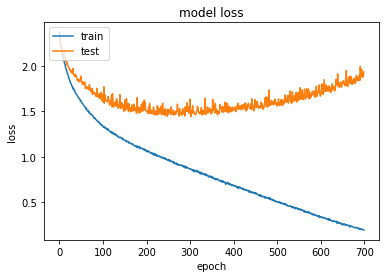

In [38]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [39]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Lenovo\Speech-Emotion-Analyzer\saved_models\Emotion_Voice_Detection_Model.h5 


In [40]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [41]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 48.68%


## Predicting emotions on the test data

In [42]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

6/6 [==============================] - 0s 11ms/step


In [43]:
preds

array([[6.6372075e-07, 5.6617980e-20, 2.1966196e-10, ..., 1.7223375e-04,
        1.3149664e-05, 4.4287571e-01],
       [1.2858229e-02, 5.8427150e-04, 7.5937157e-07, ..., 4.0738988e-03,
        7.7511589e-03, 7.5503215e-02],
       [1.9757829e-03, 2.3442502e-04, 7.0786893e-01, ..., 3.2013268e-04,
        4.5735823e-04, 6.2874588e-04],
       ...,
       [5.2726506e-03, 8.0996990e-01, 3.6627925e-03, ..., 1.5849842e-05,
        3.3580528e-03, 2.2859509e-04],
       [3.7755311e-02, 7.2626921e-05, 2.6699435e-03, ..., 7.7923976e-02,
        8.1909271e-03, 5.0867838e-03],
       [1.5850808e-01, 4.0525543e-03, 1.3204124e-04, ..., 2.7042329e-02,
        6.6485312e-03, 7.6728195e-02]], dtype=float32)

In [44]:
preds1=preds.argmax(axis=1)

In [45]:
preds1

array([6, 6, 2, 0, 4, 6, 2, 5, 9, 8, 0, 7, 4, 6, 1, 0, 6, 2, 0, 9, 1, 7,
       4, 8, 4, 4, 6, 3, 0, 9, 8, 4, 4, 9, 4, 3, 9, 7, 0, 5, 4, 5, 5, 3,
       3, 7, 9, 0, 7, 0, 6, 6, 7, 3, 2, 8, 8, 8, 6, 0, 8, 4, 9, 9, 8, 9,
       5, 0, 8, 3, 6, 3, 8, 5, 3, 7, 9, 4, 4, 2, 9, 0, 9, 2, 6, 5, 3, 9,
       9, 5, 7, 8, 0, 3, 5, 7, 5, 7, 7, 6, 9, 5, 0, 2, 3, 3, 4, 1, 8, 3,
       6, 8, 4, 3, 3, 5, 5, 3, 6, 5, 3, 4, 3, 6, 2, 5, 0, 8, 0, 9, 9, 9,
       6, 0, 4, 5, 2, 8, 4, 3, 3, 2, 2, 4, 5, 6, 0, 0, 1, 0, 8, 3, 4, 2,
       8, 1, 0, 3, 9, 4, 1, 6, 3, 8, 5, 7, 6, 7, 4, 3, 2, 3, 7, 4, 2, 9,
       4, 1, 2, 5, 2, 5, 3, 7, 4, 5, 1, 5, 4], dtype=int64)

In [46]:
abc = preds1.astype(int).flatten()

In [47]:
predictions = (lb.inverse_transform((abc)))

In [48]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_calm
2,female_fearful
3,female_angry
4,female_sad
5,male_calm
6,female_fearful
7,male_angry
8,male_sad
9,male_happy


In [49]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [50]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_fearful
1,male_calm
2,female_fearful
3,female_angry
4,female_angry
5,male_sad
6,female_fearful
7,male_happy
8,male_calm
9,male_happy


In [51]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [53]:
finaldf[160:180]

,actualvalues,predictedvalues
160,female_sad,female_calm
161,male_sad,male_calm
162,female_sad,female_happy
163,male_angry,male_happy
164,male_angry,male_angry
165,female_calm,male_fearful
166,male_sad,male_calm
167,male_angry,male_fearful
168,female_sad,female_sad
169,female_fearful,female_happy


In [56]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,17
female_fearful,20
female_happy,23
female_sad,15
male_angry,22
male_calm,20
male_fearful,16
male_happy,15


In [57]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,20
female_calm,8
female_fearful,16
female_happy,26
female_sad,25
male_angry,22
male_calm,19
male_fearful,15
male_happy,18


In [58]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [59]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


c:\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


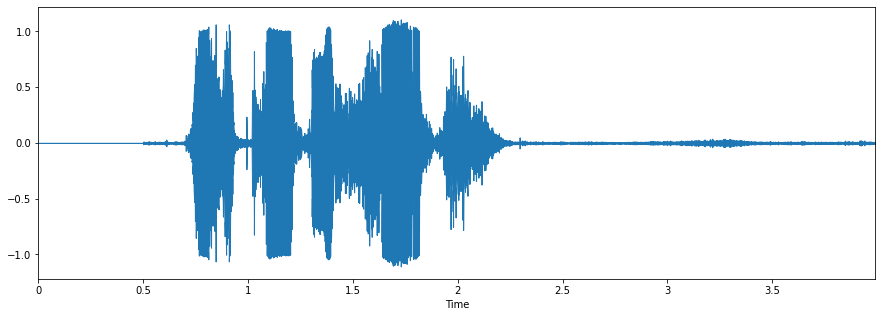

In [61]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [62]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [63]:
livedf2= pd.DataFrame(data=livedf2)

In [64]:
livedf2 = livedf2.stack().to_frame().T

In [65]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.20356,-21.471832,-22.522209,-21.712261,-22.264282,-20.707907,-21.72644,-21.768646,-24.302736,-22.250633,...,-24.273821,-24.63994,-24.929155,-24.439188,-25.210173,-24.740648,-22.311916,-22.579805,-22.314659,-21.552433


In [66]:
twodim= np.expand_dims(livedf2, axis=2)

In [67]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 13ms/step


In [68]:
livepreds

array([[3.4010443e-01, 2.3365183e-18, 6.8251001e-07, 2.9500481e-04,
        1.0042571e-07, 1.1270484e-04, 3.7246055e-03, 6.5384269e-01,
        9.8745273e-05, 1.8210328e-03]], dtype=float32)

In [69]:
livepreds1=livepreds.argmax(axis=1)

In [70]:
liveabc = livepreds1.astype(int).flatten()

In [71]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_fearful'], dtype=object)

In [75]:
import h5py

filename = "saved_models/Emotion_Voice_Detection_Model.h5"

h5 = h5py.File(filename,'r')

#futures_data = h5['futures_data']  # VSTOXX futures data
#options_data = h5['options_data']  # VSTOXX call option data

#h5.close()

AttributeError: 'File' object has no attribute 'open'